In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.auto import tqdm
import pandas as pd

#import tensorflow.gfile as gfile
#from tensorflow.gfile import Glob
import pickle

import numpy as np
import pylab as plt
import pandas as pd
import tensorflow as tf
import pickle

#load the data "M_100.pkl" using pickle
with open('M_100.pkl', 'rb') as f:
    Ms = pickle.load(f)
with open('ks', 'rb') as f:
    ks = pickle.load(f)

#Ms, ks = load('cifar10-resnet18k-p15-adam-reps')

def gload(gsname):
    with gfile.GFile(gsname, "rb") as file:
        obj = pickle.load(file)
    return obj

In [3]:
Ms, ks = gload('dd_cifar100-resnet18k-50k-adam_Mlist'), gload('dd_cifar100-resnet18k-50k-adam_ks')

C:\Users\Mikkel Groengaard\AppData\Local\Temp\ipykernel_28952\3762944607.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(name)
C:\Users\Mikkel Groengaard\AppData\Local\Temp\ipykernel_28952\3762944607.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(i) / np.log(maxIdx)
C:\Users\Mikkel Groengaard\AppData\Local\Temp\ipykernel_28952\3762944607.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha=min(0.2*np.sqrt(s)+0.2, 1)


ValueError: alpha (nan) is outside 0-1 range

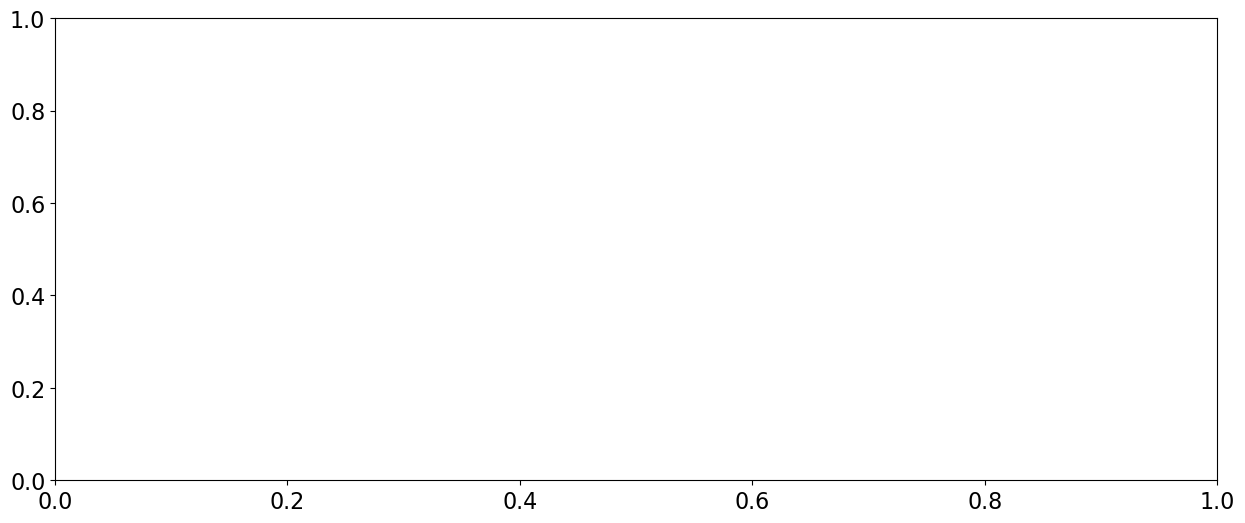

In [6]:
def plot_dynamics(Ms, ks, base = 1.1, metric='Test Error', title='', xlabel='ResNet18 width parameter', p=0.0):  
    # p: noise parameter (for noisy-test)
    
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'legend.frameon': False})
    
    def rescale_cmap(name, rescale):
        cmap = plt.cm.get_cmap(name)
        colors = []
        for i in range(256):
            x = i/256
            colors += [cmap(rescale(x))]
        return matplotlib.colors.ListedColormap(colors)

    def scale(maxIdx, i):
        return np.log(i) / np.log(maxIdx)


    M = Ms[metric]
    if metric == 'Test Error':
        M = 1.0 - (1-p)*(1-M) + M*p/9.0 # noisy test
    
    # base = 1.1 works well. 1.01 for dense
    maxIdx = M.shape[1]
    idx = np.unique(np.array(base**np.arange(0, np.log(maxIdx)/np.log(base)), dtype=int) - 1)
    
    
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
    
    # cos: skews more colors to the middle of the range
    # x**a: skews more colors towards the beginning/end of the range for larger/smaller a
    # p cos(...) + q x: controls strength of rescaling
    cmap = rescale_cmap('viridis', lambda x: 0.5 * (1 - np.cos(np.pi * x**0.7)) / 2 + 0.5 * x)
    for j, i in enumerate(idx):
        #s = j / len(idx)
        s = scale(maxIdx, i)
        
        alpha=min(0.2*np.sqrt(s)+0.2, 1)
        if s == 1.0:
            alpha = 1.0
        ax1.plot(ks, M[:, i], linestyle='-', color=cmap(1.0-s), alpha=alpha)
        
        
    ax1.plot(ks, M.min(axis=1), linestyle='dashed', color='red', lw=2.5, label='Optimal Early Stopping')
        
    ax1.set_ylabel(metric)
    ax1.set_xlabel(xlabel)
    ax1.xaxis.labelpad = 10
    ax1.yaxis.labelpad = 5
    #ax1.spines['top'].set_visible(False)
    #ax1.spines['right'].set_visible(False)
    ax1.legend()
    plt.tight_layout()
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    
    ticks = 1 - scale(maxIdx, [1, 10, 100, 1000])
    #print(ticks)
    
    cb = plt.colorbar(sm, cmap=cmap, ticks=ticks)
    cb.ax.set_yticklabels(['1', '10', '100', '1000']) 
    cb.set_label('Epochs')
    
    fig.suptitle(title)
    return fig

fig = plot_dynamics(Ms[1], ks, base = 1.1, metric='Test Error', title='', p=0.15 )

[  0   1   2   3   4   5   6   7   8   9  10  12  13  14  16  18  20  22
  24  27  29  33  36  40  44  48  53  59  65  71  79  87  96 105 116 128
 141 155 170 188 206 227 250 275 303 333 367 404 444 489 538 592 651 716
 788 867 954]
[0, 9, 32, 56]
57


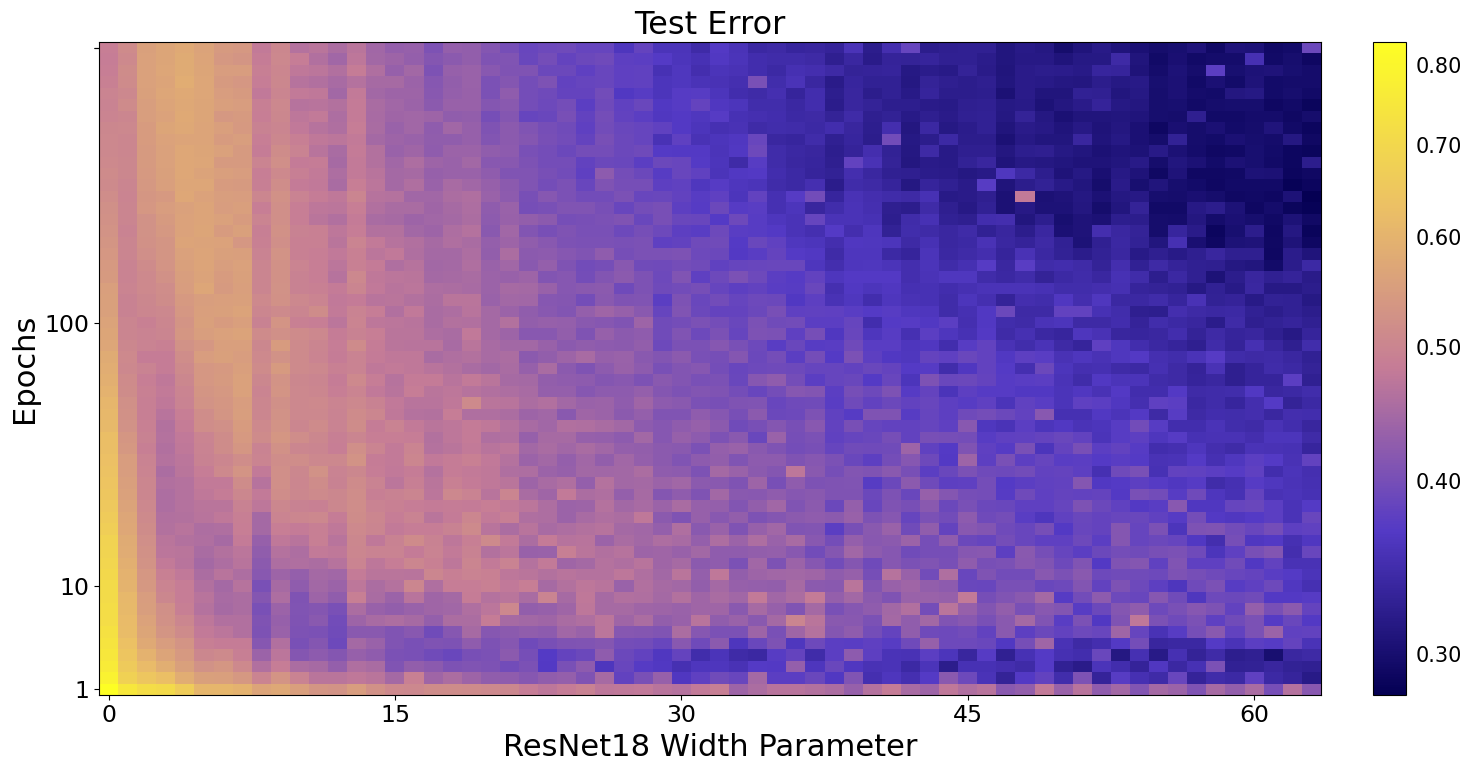

In [4]:
def plot_ocean(Ms, ks, base, sup_title='', title = 'Test Error',
               contours=[0.15, 0.5],
               x_ticks_fs = 17, y_ticks_fs = 17, x_label_fs = 22, y_label_fs = 22, cbar_fs = 15, title_fs = 23):
    
    def x_fmt(x):
        decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
        suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
        if x == 0:
            return str(0)
        for i, d in enumerate(decades):
            if np.abs(x) >= d:
                val = x/float(d)
                signf = len(str(val).split(".")[1])
                if signf == 0:
                    return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
                else:
                    if signf == 1:
                        if str(val).split(".")[1] == "0":
                            return '{val:d}{suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                    tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                    return tx.format(val=val, suffix=suffix[i])
        return x

    # Get steps grid, number of parameters
    
    max_steps = Ms[title].shape[1]
    eps = np.unique(np.array(base**np.arange(0, np.log(max_steps)/np.log(base)), dtype=int)-1)
    print(eps)
    # Colormap
    with open('custom_colormaps/colormap_inferno_strong_1.txt', 'r') as f:
        a = f.read()
    C = [list(map(int, val.split(' '))) for val in a.split('\n')[:-1]]
    #C = C[:-50]
        
    cm = mpl.colors.ListedColormap(np.array(C)/255.0)

    # Start plotting
    fig = plt.figure(figsize=(15, 8))
    ax = fig.gca()
    

    M = Ms[title][:, eps].T

    if title == 'Test Error':
        im = ax.imshow(M, cmap=cm, norm=colors.LogNorm(vmin=np.min(M), vmax=np.max(M)),
                      aspect='auto',
                   interpolation='none')  
    elif title == 'Train Error':
        im = ax.imshow(M, cmap=cm, norm=colors.Normalize(vmin=np.min(M), vmax=0.8),
                       aspect='auto',
                   interpolation='none')

    if contours is not None:
        ax.contour(Ms['Train Error'][:, eps].T, levels=contours, colors='white', linestyles='dashed', alpha=0.7)

    
    # Y-axis

    ten_powers = 10 ** np.arange(10) - 1
    ten_powers = ten_powers[ten_powers < max_steps]

    yvals = eps
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(yvals-val))]
    print(indices)
    print(len(eps))
    
    ax.set_yticks(np.arange(len(eps)))
    ax.set_yticks(indices + [len(eps)-1])
    ax.set_yticklabels([x_fmt(val+1) for val in ten_powers] + [''], fontsize=y_ticks_fs)
    ax.set_ylabel('Epochs', fontsize=y_label_fs)
    ax.invert_yaxis()

    # X-axis
    x_idx = np.arange(M.shape[1])[::15]
    x_vals = x_idx
    x_labs = ['%d' % (n) for n in x_vals]
    ax.set_xticks(x_idx)
    ax.set_xticklabels(x_labs, fontsize=x_ticks_fs)
    ax.set_xlabel('ResNet18 Width Parameter', fontsize=x_label_fs)

    
    # Colorbar
    ticks = np.linspace(0.0, 0.8, 9)
    cbar = fig.colorbar(im, fraction=0.025, pad=0.04, ticks=ticks)
    #cbar.set_ticks(ticks)
    
    cbar.ax.get_yaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
    cbar.ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    cbar.ax.minorticks_off()
    
    cbar.ax.set_yticklabels(['%.2f'%val for val in ticks])
    
    cbar.ax.tick_params(labelsize=cbar_fs) 
    cbar.ax.tick_params(right=False)

    ax.set_title(title, fontsize=title_fs)
        
    plt.tight_layout()
    fig.suptitle(sup_title, fontsize=title_fs)
    return fig

#p = 0.1 
#noise_lvl = {0:0, 0.1:1, 0.2:2}[p]

#Ms, ks = load('pct-cifar10-resnet18-50k-p15-adam')
#fig, ax = plot_ocean(Ms[0], ks, title='Test Error', base = 1.1)
fig = plot_ocean(Ms[0], ks, title='Test Error', base = 1.1, contours=None)